In [480]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import rasterio
import pyvista as pv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Cropping2D
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os
import vtk
from vtk.util import numpy_support as VN
from skimage.metrics import structural_similarity as ssim


In [446]:
def read_in_vtk(vtk_filename):
    reader = vtk.vtkStructuredGridReader()
        
    reader.SetFileName( vtk_filename )
    reader.ReadAllVectorsOn()
    reader.ReadAllScalarsOn() 
    reader.Update()
    
    data = reader.GetOutput()
    
    dim = [0,0,0] 
    data.GetDimensions(dim)
    vec = list(dim)
    vec.append(3)
    
    vel_pts = VN.vtk_to_numpy(data.GetPointData().GetArray('wind_vectors'))  ## wind_vectors is NOT seen in the file? But print data showed it, so that's what I used, looks like it worked
    
    vel_3D = vel_pts.reshape(vec,order='F')
    
    U = vel_3D[:,:,:,0]
    V = vel_3D[:,:,:,1]
    W = vel_3D[:,:,:,2]

    return U,V

In [447]:
sample_factor = 4
size = 128

In [448]:
def get_mass_momentum_diff(file_number, wind_direction_folder, wind_direction_file, plot=True):
    mass_angle_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/mass/grass/{wind_direction_folder}/{wind_direction_file}ang.asc"
    mass_vel_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/mass/grass/{wind_direction_folder}/{wind_direction_file}vel.asc"

    momentum_angle_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/momentum/grass/{wind_direction_folder}/{wind_direction_file}ang.asc"
    momentum_vel_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/momentum/grass/{wind_direction_folder}/{wind_direction_file}vel.asc"

    with rasterio.open(mass_angle_file) as ang_src_mass, rasterio.open(mass_vel_file) as vel_src_mass:
        angle_mass = ang_src_mass.read(1)  # Wind direction in degrees
        velocity_mass = vel_src_mass.read(1)  # Wind speed in m/s
        transform_mass = ang_src_mass.transform  # Georeferencing
        width_mass, height_mass = ang_src_mass.width, ang_src_mass.height  # Raster dimensions

    # Convert wind direction to U, V components for quiver plot
    angle_rad_mass = np.radians(angle_mass)  # Convert degrees to radians
    U_mass = velocity_mass * np.cos(angle_rad_mass)  # X component
    V_mass = velocity_mass * np.sin(angle_rad_mass)  # Y component
    N_orig = U_mass.shape[0]
    # Downsample for visualization (adjust factor for performance)
    X_mass, Y_mass = np.meshgrid(np.arange(0, width_mass, sample_factor), np.arange(0, height_mass, sample_factor))
    U_sampled_mass = U_mass[::sample_factor, ::sample_factor]
    V_sampled_mass = V_mass[::sample_factor, ::sample_factor]

    with rasterio.open(momentum_angle_file) as ang_src_momentum, rasterio.open(momentum_vel_file) as vel_src_momentum:
        angle_momentum = ang_src_momentum.read(1)  # Wind direction in degrees
        velocity_momentum = vel_src_momentum.read(1)  # Wind speed in m/s
        transform_momentum = ang_src_momentum.transform  # Georeferencing
        width_momentum, height_momentum = ang_src_momentum.width, ang_src_momentum.height  # Raster dimensions

    # Convert wind direction to U, V components for quiver plot
    angle_rad_momentum = np.radians(angle_momentum)  # Convert degrees to radians
    U_momentum = velocity_momentum * np.cos(angle_rad_momentum)  # X component
    V_momentum = velocity_momentum * np.sin(angle_rad_momentum)  # Y component

    # Downsample for visualization (adjust factor for performance)
    X_momentum, Y_momentum = np.meshgrid(np.arange(0, width_momentum, sample_factor), np.arange(0, height_momentum, sample_factor))
    U_sampled_momentum = U_momentum[::sample_factor, ::sample_factor]
    V_sampled_momentum = V_momentum[::sample_factor, ::sample_factor]

    # print(mean_squared_error(U_sampled_mass, U_sampled_momentum))
    # calculate the difference
    U_diff = U_sampled_momentum - U_sampled_mass
    V_diff = V_sampled_momentum - V_sampled_mass

    min_dimension = np.min([U_diff.shape[0], U_diff.shape[1]])
    U_diff = U_diff[:size, :size]
    V_diff = V_diff[:size, :size]

    X_diff = X_mass[:size, :size]
    Y_diff = Y_mass[:size, :size]


    elevation = get_elevation_file(file_number)
    # plot

    if plot:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
        im1 = ax1.imshow(velocity_mass, cmap="coolwarm", origin="upper")  # Wind speed heatmap
        #ax1.imshow(elevation, extent=[0, min_dimension, min_dimension, 0])
        ax1.quiver(X_mass, Y_mass, U_sampled_mass, -V_sampled_mass, scale=300, color="black")  # Wind direction arrows

        ax1.set_title("Mass Solver")
        ax1.set_xlabel("X")
        ax1.set_ylabel("Y")

        #im2 = ax2.imshow(velocity_momentum, cmap="coolwarm", origin="upper")  # Wind speed heatmap
        #ax2.imshow(elevation, extent=[0, min_dimension, min_dimension, 0])
        ax2.quiver(X_momentum, Y_momentum, U_sampled_momentum, -V_sampled_momentum, scale=300, color="black")  # Wind direction arrows

        ax2.set_title("Momentum Solver")
        ax2.set_xlabel("X")
        ax2.set_ylabel("Y")

        fig.tight_layout()
        plt.show()

        # plot the difference...
        fig = plt.figure(figsize=(10,8))
        
        plt.imshow(elevation, extent=[0, N_orig, N_orig, 0], cmap="coolwarm", origin="upper")
        plt.quiver(X_diff, Y_diff, U_diff, -V_diff, scale=300, color="black")
        plt.title("Difference")
        plt.xlabel('X')
        plt.ylabel("Y")
        plt.show()

    return U_diff, V_diff
    


In [449]:
U_temp, V_temp = get_mass_momentum_diff(25, wind_direction_folder_names[0], wind_direction_file_names[0], plot=False)
print(U_temp.shape)

(128, 128)


In [450]:
def split_elevation(elevation, N, plot=True):
    rows, cols = elevation.shape


    if N >= rows or N >= cols:
        N = min(rows, cols) - 1

    block_size_x = rows // N
    block_size_y = cols // N
    new_elevation = np.zeros((N,N))

    for i in range(N):
        for j in range(N):
            block = elevation[i * block_size_x:(i + 1) * block_size_x, j * block_size_y:(j + 1) * block_size_y]
            
            new_elevation[i, j] = np.mean(block)
    
    if plot:
        figure = plt.figure(figsize=(10,12))
        
        ax1 = figure.add_subplot(121)
        ax1.imshow(elevation)
        ax1.set_title("Original Elevation")

        
        ax2 = figure.add_subplot(122)
        ax2.imshow(new_elevation)
        ax2.set_title(f"Approximated Elevation, N = {N}")
        plt.show()

    return new_elevation




In [451]:
def get_elevation_file(file_number):
    elevation_tif = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/dem0.tif"
    with rasterio.open(elevation_tif) as src:
        elevation = src.read(1)  # Reads all bands into a NumPy array
        elevation_npy = np.array(elevation)


    elevation_approx = split_elevation(elevation_npy, size, plot=False)
    return elevation_approx


In [452]:
def get_mass_grid(file_number, wind_direction_file, wind_direction_folder):
    mass_angle_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/mass/grass/{wind_direction_folder}/{wind_direction_file}ang.asc"
    mass_vel_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/mass/grass/{wind_direction_folder}/{wind_direction_file}vel.asc"
    
    with rasterio.open(mass_angle_file) as ang_src_mass, rasterio.open(mass_vel_file) as vel_src_mass:
        angle_mass = ang_src_mass.read(1)  # Wind direction in degrees
        velocity_mass = vel_src_mass.read(1)  # Wind speed in m/s
        transform_mass = ang_src_mass.transform  # Georeferencing
        width_mass, height_mass = ang_src_mass.width, ang_src_mass.height  # Raster dimensions

    # Convert wind direction to U, V components for quiver plot
    angle_rad_mass = np.radians(angle_mass)  # Convert degrees to radians
    U_mass = velocity_mass * np.cos(angle_rad_mass)  # X component
    V_mass = velocity_mass * np.sin(angle_rad_mass)  # Y component

    # Downsample for visualization (adjust factor for performance)
    sample_factor = 4  # Change this to control arrow density
    X_mass, Y_mass = np.meshgrid(np.arange(0, width_mass, sample_factor), np.arange(0, height_mass, sample_factor))
    U_sampled_mass = U_mass[::sample_factor, ::sample_factor]
    V_sampled_mass = V_mass[::sample_factor, ::sample_factor]

    U_sampled_mass = U_sampled_mass[:size, :size]
    V_sampled_mass = V_sampled_mass[:size, :size]

    return U_sampled_mass, V_sampled_mass

In [486]:
def get_momentum_grid(file_number, wind_direction_file, wind_direction_folder):
    mass_angle_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/momentum/grass/{wind_direction_folder}/{wind_direction_file}ang.asc"
    mass_vel_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/momentum/grass/{wind_direction_folder}/{wind_direction_file}vel.asc"
    
    with rasterio.open(momentum_angle_file) as ang_src_momentum, rasterio.open(momentum_vel_file) as vel_src_momentum:
        angle_momentum = ang_src_momentum.read(1)  # Wind direction in degrees
        velocity_momentum = vel_src_momentum.read(1)  # Wind speed in m/s
        transform_momentum = ang_src_momentum.transform  # Georeferencing
        width_momentum, height_momentum = ang_src_momentum.width, ang_src_momentum.height  # Raster dimensions

    # Convert wind direction to U, V components for quiver plot
    angle_rad_momentum = np.radians(angle_momentum)  # Convert degrees to radians
    U_mass = velocity_momentum * np.cos(angle_rad_momentum)  # X component
    V_mass = velocity_momentum * np.sin(angle_rad_momentum)  # Y component

    # Downsample for visualization (adjust factor for performance)
    sample_factor = 4  # Change this to control arrow density
    X_momentum, Y_momentum = np.meshgrid(np.arange(0, width_momentum, sample_factor), np.arange(0, height_momentum, sample_factor))
    U_sampled_momentum = U_momentum[::sample_factor, ::sample_factor]
    V_sampled_momentum = V_momentum[::sample_factor, ::sample_factor]

    U_sampled_momentum = U_sampled_momentum[:size, :size]
    V_sampled_momentum = V_sampled_momentum[:size, :size]

    return U_sampled_momentum, V_sampled_momentum

In [453]:
def should_use_num(file_number, wind_direction_file, wind_direction_folder):

    mass_angle_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/mass/grass/{wind_direction_folder}/{wind_direction_file}ang.asc"
    mass_vel_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/mass/grass/{wind_direction_folder}/{wind_direction_file}vel.asc"
    momentum_angle_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/momentum/grass/{wind_direction_folder}/{wind_direction_file}ang.asc"
    momentum_vel_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/momentum/grass/{wind_direction_folder}/{wind_direction_file}vel.asc"
    elevation_tif = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/dem0.tif"

    if not os.path.exists(mass_angle_file):
        return False
    
    if not os.path.exists(mass_vel_file):
        return False
    
    if not os.path.exists(momentum_angle_file):
        return False
    
    if not os.path.exists(momentum_vel_file):
        return False
    
    if not os.path.exists(elevation_tif):
        return False
    
    return True

In [454]:
# Lists to store data
X_train_list, y_train_list = [], []


wind_direction_folder_names = ['0o0deg', '22o5deg', '45o0deg', '67o5deg', '90o0deg', '112o5deg', '135o0deg', '157o5deg', '180o0deg', '202o5deg', '225o0deg', '247o5deg', '270o0deg', '292o5deg', '315o0deg', '337o5deg']
wind_direction_file_names = ['dem0_0_5_100m_', 'dem0_23_5_100m_', 'dem0_45_5_100m_', 'dem0_68_5_100m_', 'dem0_90_5_100m_', 'dem0_113_5_100m_', 'dem0_135_5_100m_', 'dem0_158_5_100m_', 'dem0_180_5_100m_', 'dem0_203_5_100m_', 'dem0_225_5_100m_', 'dem0_248_5_100m_', 'dem0_270_5_100m_', 'dem0_293_5_100m_', 'dem0_315_5_100m_', 'dem0_338_5_100m_']

for file_num in range(10,200):  
    print("File Number: ", file_num)
    
    for i in range(16):

        wind_direction_folder = wind_direction_folder_names[i]
        wind_direction_file = wind_direction_file_names[i]
        # Load data for this file
        if not should_use_num(file_num, wind_direction_file, wind_direction_folder):
            continue


        U_diff, V_diff = get_mass_momentum_diff(file_num, wind_direction_folder, wind_direction_file, plot=False)
        elevation = get_elevation_file(file_num)
        U_mass, V_mass = get_mass_grid(file_num, wind_direction_file, wind_direction_folder)

        # Convert to NumPy arrays (if they aren't already)
        U_diff, V_diff = np.array(U_diff), np.array(V_diff)
        elevation = np.array(elevation)
        U_mass, V_mass = np.array(U_mass), np.array(V_mass)

        # Ensure correct shape (size, size)
        assert U_diff.shape == (size, size) and V_diff.shape == (size, size)
        assert elevation.shape == (size, size)
        assert U_mass.shape == (size, size) and V_mass.shape == (size, size)

        # Stack inputs into a (size, size, 3) tensor
        X_sample = np.stack([elevation, U_mass, V_mass], axis=-1)  # Shape: (size, size, 3)

        # Stack targets into a (size, size, 2) tensor
        y_sample = np.stack([U_diff, V_diff], axis=-1)  # Shape: (size, size, 2)
        # Append to lists
        X_train_list.append(X_sample)
        y_train_list.append(y_sample)

# Convert lists to NumPy arrays
X_train = np.array(X_train_list)  # Shape: (10, size, size, 3)
y_train = np.array(y_train_list)  # Shape: (10, size, size, 2)


# Convert to TensorFlow tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)

print(X_train.shape)


File Number:  10
File Number:  11
File Number:  12
File Number:  13
File Number:  14
File Number:  15
File Number:  16
File Number:  17
File Number:  18
File Number:  19
File Number:  20
File Number:  21
File Number:  22
File Number:  23
File Number:  24
File Number:  25
File Number:  26
File Number:  27
File Number:  28
File Number:  29
File Number:  30
File Number:  31
File Number:  32
File Number:  33
File Number:  34
File Number:  35
File Number:  36
File Number:  37
File Number:  38
File Number:  39
File Number:  40
File Number:  41
File Number:  42
File Number:  43
File Number:  44
File Number:  45
File Number:  46
File Number:  47
File Number:  48
File Number:  49
File Number:  50
File Number:  51
File Number:  52
File Number:  53
File Number:  54
File Number:  55
File Number:  56
File Number:  57
File Number:  58
File Number:  59
File Number:  60
File Number:  61
File Number:  62
File Number:  63
File Number:  64
File Number:  65
File Number:  66
File Number:  67
File Number:  

In [503]:
print("MSE of mass and CFD solver: ")
original_mse = np.mean(np.square(np.abs(X_train[:,:,:,1:])))
print(original_mse)


MSE of mass and CFD solver: 
61.635513


In [455]:
# Example shape
input_shape = (size, size, 3)  # Elevation (1 channel) + Mass solver (2 channels)
output_shape = (size, size, 2)  # Target difference (2 channels)

# Define CNN Model
def build_cnn():
    inputs = keras.Input(shape=input_shape)

    # Encoder
    
    x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    
    x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2,2))(x)

    # Bottleneck
    x = layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)

    # Decoder
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
    
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(x)

    # Output layer
    outputs = layers.Conv2D(2, (1,1), activation="linear", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

# Create model
model = build_cnn()
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()


Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_70 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_914 (Conv2D)             │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_239               │ (None, 64, 64, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_915 (Conv2D)             │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_240               │ (None, 32, 32, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_916 (Conv2D)             │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_32 (UpSampling2D) │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_917 (Conv2D)             │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_33 (UpSampling2D) │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_918 (Conv2D)             │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_919 (Conv2D)             │ (None, 128, 128, 2)    │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,570 (724.88 KB)

 Trainable params: 185,570 (724.88 KB)

 Non-trainable params: 0 (0.00 B)

In [456]:
# Example training
# model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2)


In [457]:
def unet(input_shape=(64, 64, 3)):
    inputs = layers.Input(shape=input_shape)

    # Encoder (Downsampling)
    c1 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(p2)
    c3 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(p3)
    c4 = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation="relu", padding="same")(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation="relu", padding="same")(c5)

    # Decoder (Upsampling)
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding="same")(c5)
    u6 = layers.Concatenate()([u6, c4])  # Skip connection
    c6 = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(u6)
    c6 = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(c6)
    u7 = layers.Concatenate()([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(u7)
    c7 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(c7)
    u8 = layers.Concatenate()([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(u8)
    c8 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c8)
    u9 = layers.Concatenate()([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(u9)
    c9 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c9)

    # Output layer (segmentation mask)
    outputs = layers.Conv2D(2, (1, 1), activation="linear")(c9)  

    model = Model(inputs, outputs)
    return model

# Example usage:
unet_model = unet(input_shape=(128, 128, 3))
unet_model.compile(optimizer="adam", loss="mae", metrics=["mse"])
unet_model.summary()



Model: "functional_44"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_71      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_920 (Conv2D) │ (None, 128, 128,  │      1,792 │ input_layer_71[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_921 (Conv2D) │ (None, 128, 128,  │     36,928 │ conv2d_920[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_241   │ (None, 64, 64,    │          0 │ conv2d_921[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_922 (Conv2D) │ (None, 64, 64,    │     73,856 │ max_pooling2d_24… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_923 (Conv2D) │ (None, 64, 64,    │    147,584 │ conv2d_922[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_242   │ (None, 32, 32,    │          0 │ conv2d_923[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_924 (Conv2D) │ (None, 32, 32,    │    295,168 │ max_pooling2d_24… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_925 (Conv2D) │ (None, 32, 32,    │    590,080 │ conv2d_924[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_243   │ (None, 16, 16,    │          0 │ conv2d_925[0][0]  │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_926 (Conv2D) │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_24… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_927 (Conv2D) │ (None, 16, 16,    │  2,359,808 │ conv2d_926[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_244   │ (None, 8, 8, 512) │          0 │ conv2d_927[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_928 (Conv2D) │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_24… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_929 (Conv2D) │ (None, 8, 8,      │  9,438,208 │ conv2d_928[0][0]  │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1… │ (None, 16, 16,    │  2,097,664 │ conv2d_929[0][0]  │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_136     │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,031,810 (118.38 MB)

 Trainable params: 31,031,810 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [458]:
unet_model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.2)



Epoch 1/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 422s 4s/step - loss: 19.7143 - mse: 2450.6575 - val_loss: 1.8549 - val_mse: 7.3013
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 537s 5s/step - loss: 1.4035 - mse: 4.8777 - val_loss: 1.4346 - val_mse: 4.8801
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 426s 4s/step - loss: 1.1962 - mse: 3.6430 - val_loss: 1.3270 - val_mse: 4.5555
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 426s 4s/step - loss: 1.1820 - mse: 3.6226 - val_loss: 1.3527 - val_mse: 4.5404
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 412s 4s/step - loss: 1.2050 - mse: 3.7190 - val_loss: 1.3170 - val_mse: 4.4916
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 397s 4s/step - loss: 1.1622 - mse: 3.5186 - val_loss: 1.3120 - val_mse: 4.4557
Epoch 7/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 394s 4s/step - loss: 1.1038 - mse: 3.2735 - val_loss: 1.3286 - val_mse: 4.2847
Epoch 8/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 402s 4s/step - loss: 1.1236 - mse: 3.3038 - val_loss: 1.3026 - val_mse: 4.3641
Epoch 9/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 403s

In [477]:
def small_unet(input_shape=(64, 64, 3)):
    inputs = layers.Input(shape=input_shape)

    # Encoder (Downsampling)
    c1 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)


    # Bottleneck
    c5 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(p2)
    c5 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(c5)

    # Decoder (Upsampling)
    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(c5)
    u6 = layers.Concatenate()([u6, c2])  # Skip connection
    c6 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(u6)
    c6 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c6)

    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c6)
    u7 = layers.Concatenate()([u7, c1])
    c7 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(u7)
    c7 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c7)


    # Output layer (segmentation mask)
    outputs = layers.Conv2D(2, (1, 1), activation="linear")(c7)  

    model = Model(inputs, outputs)
    return model

# Example usage:
small_unet_model = small_unet(input_shape=(128, 128, 3))
small_unet_model.compile(optimizer="adam", loss="mae", metrics=["mse"])
small_unet_model.summary()



Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_73      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_945 (Conv2D) │ (None, 128, 128,  │      1,792 │ input_layer_73[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_946 (Conv2D) │ (None, 128, 128,  │     36,928 │ conv2d_945[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_247   │ (None, 64, 64,    │          0 │ conv2d_946[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_947 (Conv2D) │ (None, 64, 64,    │     73,856 │ max_pooling2d_24… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_948 (Conv2D) │ (None, 64, 64,    │    147,584 │ conv2d_947[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_248   │ (None, 32, 32,    │          0 │ conv2d_948[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_949 (Conv2D) │ (None, 32, 32,    │    295,168 │ max_pooling2d_24… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_950 (Conv2D) │ (None, 32, 32,    │    590,080 │ conv2d_949[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1… │ (None, 64, 64,    │    131,200 │ conv2d_950[0][0]  │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_141     │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_948[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_951 (Conv2D) │ (None, 64, 64,    │    295,040 │ concatenate_141[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_952 (Conv2D) │ (None, 64, 64,    │    147,584 │ conv2d_951[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1… │ (None, 128, 128,  │     32,832 │ conv2d_952[0][0]  │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_142     │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_946[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_953 (Conv2D) │ (None, 128, 128,  │     73,792 │ concatenate_142[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_954 (Conv2D) │ (None, 128, 128,  │     36,928 │ conv2d_953[0][0]

 Total params: 1,862,914 (7.11 MB)

 Trainable params: 1,862,914 (7.11 MB)

 Non-trainable params: 0 (0.00 B)

In [478]:
small_unet_model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.2)


Epoch 1/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - loss: 7.4225 - mse: 280.1429 - val_loss: 1.8247 - val_mse: 7.0209
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - loss: 1.3524 - mse: 4.4947 - val_loss: 1.4572 - val_mse: 5.2969
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - loss: 1.2656 - mse: 4.0287 - val_loss: 1.3266 - val_mse: 4.6138
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - loss: 1.1252 - mse: 3.4116 - val_loss: 1.3267 - val_mse: 4.4058
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - loss: 1.1713 - mse: 3.5627 - val_loss: 1.3425 - val_mse: 4.3227
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - loss: 1.1095 - mse: 3.2916 - val_loss: 1.2948 - val_mse: 4.3567
Epoch 7/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - loss: 1.1246 - mse: 3.3332 - val_loss: 1.3188 - val_mse: 4.2472
Epoch 8/10
 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - loss: 1.1191 - mse: 3.2851

KeyboardInterrupt: 

In [479]:
X_test_list, y_test_list = [], []

for file_num in range(4,10):  
    print(file_num)

    for i in range(16):
        wind_direction_file = wind_direction_file_names[i]
        wind_direction_folder = wind_direction_folder_names[i]

        if not should_use_num(file_num, wind_direction_file=wind_direction_file, wind_direction_folder=wind_direction_folder):
            continue
        # Load data for this file
        U_diff, V_diff = get_mass_momentum_diff(file_num, wind_direction_file=wind_direction_file, wind_direction_folder=wind_direction_folder, plot=False)
        elevation = get_elevation_file(file_num)
        U_mass, V_mass = get_mass_grid(file_num, wind_direction_file=wind_direction_file, wind_direction_folder=wind_direction_folder)

        # Convert to NumPy arrays (if they aren't already)
        U_diff, V_diff = np.array(U_diff), np.array(V_diff)
        elevation = np.array(elevation)
        U_mass, V_mass = np.array(U_mass), np.array(V_mass)

        # Ensure correct shape (size, size)
        assert U_diff.shape == (size, size) and V_diff.shape == (size, size)
        assert elevation.shape == (size, size)
        assert U_mass.shape == (size, size) and V_mass.shape == (size, size)

        # Stack inputs into a (size, size, 3) tensor
        X_sample = np.stack([elevation, U_mass, V_mass], axis=-1)  # Shape: (size, size, 3)

        # Stack targets into a (size, size, 2) tensor
        y_sample = np.stack([U_diff, V_diff], axis=-1)  # Shape: (size, size, 2)

        # Append to lists
        X_test_list.append(X_sample)
        y_test_list.append(y_sample)

# Convert lists to NumPy arrays
X_test = np.array(X_test_list)  # Shape: (10, size, size, 3)
y_test = np.array(y_test_list)  # Shape: (10, size, size, 2)


# Convert to TensorFlow tensors
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

4
5
6
7
8
9


In [482]:
print(y_test.shape)
print(predictions.shape)
predictions = unet_model.predict(X_test) 


mse = mean_squared_error(y_test.numpy().flatten(), predictions.flatten())  # Flatten to make them 1D arrays
mae = mean_absolute_error(y_test.numpy().flatten(), predictions.flatten())

print(mae)
print(mse)

print(predictions.shape)
print(y_test.shape)

(96, 128, 128, 2)
(96, 128, 128, 2)
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
1.2854589
4.4989743
(96, 128, 128, 2)
(96, 128, 128, 2)


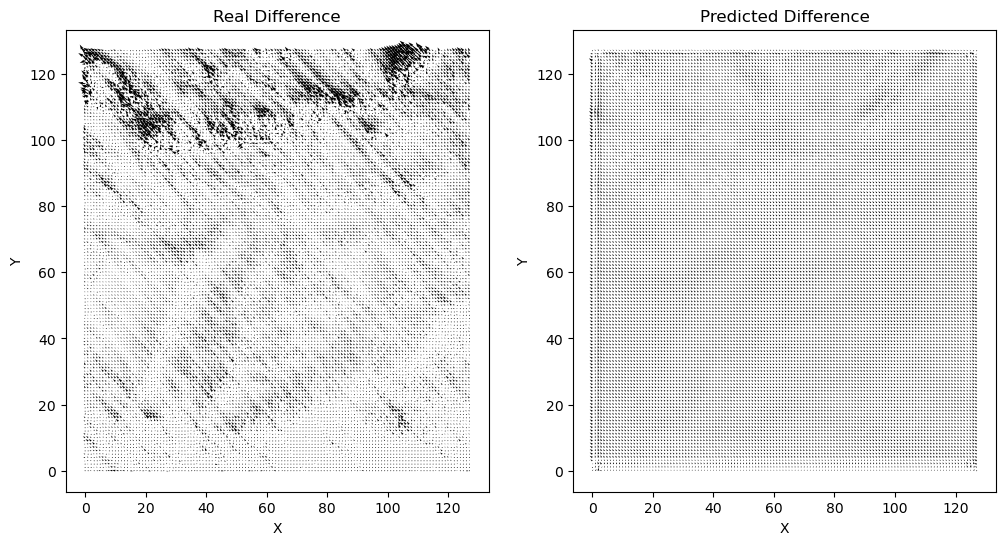

In [485]:
i = 50

U_diff_test = y_test[i, :, :, 0]
V_diff_test = y_test[i, :, :, 1]

U_diff_pred = predictions[i, :, :, 0]
V_diff_pred = predictions[i, :, :, 1]


fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.quiver(U_diff_test, -V_diff_test, scale=300, color="black")
ax1.set_title("Real Difference")
ax1.set_xlabel('X')
ax1.set_ylabel("Y")

ax2.quiver(U_diff_pred, -V_diff_pred, scale=300, color="black")
ax2.set_title("Predicted Difference")
ax2.set_xlabel('X')
ax2.set_ylabel("Y")

plt.show()


